Set up environment

```
conda create -n musicgen python=3.10
conda activate musicgen
conda install numpy matplotlib tqdm scikit-learn librosa ipython -c conda-forge
pip install pretty_midi tensorflow notebook pypianoroll
```


### Install dependencies

In [13]:
# Unconditional Symbolic Dependencies
import os
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models, losses
from tensorflow.keras.models import load_model 
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import IPython.display as ipd
from pypianoroll import Track, Multitrack
import subprocess

# Conditional Symbolic Dependencies
import seaborn as sns
from collections import Counter, defaultdict
import music21
import pandas as pd
import music21
from IPython.display import Image, Audio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#### Grab Additional Dataset

Install dependency for YouTube package for additional dataset

In [2]:
# Add another dataset
!pip install yt-dlp

Grab the videos and create midi files from them

In [3]:
# YouTube playlist URL
playlist_url = 'https://youtube.com/playlist?list=PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9&si=t2u7k51YpxxToVEV'

# Create output folder
os.makedirs('./Temp', exist_ok=True)

# Step 1: Download up to 100 audio files with their titles in the filename
download_command = [
    'yt-dlp',
    '--playlist-end', '100',  # Stop after 100 items
    '-x', '--audio-format', 'wav',
    '-o', './Temp/%(title)s.%(ext)s',  # Save as {title}.wav
    playlist_url
]

print('Downloading up to 100 WAV files...')
subprocess.run(download_command, check=True)

# Step 2: Process each downloaded WAV file to MIDI
wav_files = sorted([f for f in os.listdir('./Temp') if f.endswith('.wav')])

for wav_file in wav_files:
    wav_path = os.path.join('./Temp', wav_file)
    print(f'Processing {wav_path}...')

    try:
        # Load audio
        y, sr = librosa.load(wav_path, sr=44100)

        # Extract pitches (monophonic)
        pitches, magnitudes = librosa.piptrack(y=y, sr=sr)

        # Convert to MIDI
        midi_data = pretty_midi.PrettyMIDI()
        track = pretty_midi.Instrument(program=0)  # Piano

        for t in range(pitches.shape[1]):
            freq = pitches[:, t][magnitudes[:, t].argmax()]
            if freq > 0:
                note_num = librosa.hz_to_midi(freq)
                note = pretty_midi.Note(
                    velocity=100,
                    pitch=int(note_num),
                    start=t * 0.1,
                    end=(t + 1) * 0.1
                )
                track.notes.append(note)

        midi_data.instruments.append(track)

        # Save as {title}.mid (same base name as wav)
        midi_filename = wav_file.replace('.wav', '.mid')
        midi_path = os.path.join('./Temp', midi_filename)
        midi_data.write(midi_path)
        print(f'Saved MIDI to {midi_path}')

    except Exception as e:
        print(f'Error processing {wav_file}: {e}')


[youtube:tab] Extracting URL: https://youtube.com/playlist?list=PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9&si=t2u7k51YpxxToVEV
[youtube:tab] PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9: Downloading webpage
[youtube:tab] PLrXCURCvaqrw0SSmUSkXAwK5Ywsc857t9: Redownloading playlist API JSON with unavailable videos
[download] Downloading playlist: KPOP Piano Covers (Kpop Piano Collections, Korean Pop Songs Piano Covers) by Pianella Piano
[youtube:tab] Playlist KPOP Piano Covers (Kpop Piano Collections, Korean Pop Songs Piano Covers) by Pianella Piano: Downloading 100 items of 645
[download] Downloading item 1 of 100
[youtube] Extracting URL: https://www.youtube.com/watch?v=HXrY93tPu4c
[youtube] HXrY93tPu4c: Downloading webpage
[youtube] HXrY93tPu4c: Downloading tv client config
[youtube] HXrY93tPu4c: Downloading tv player API JSON
[youtube] HXrY93tPu4c: Downloading ios player API JSON
[youtube] HXrY93tPu4c: Downloading m3u8 information
[info] HXrY93tPu4c: Downloading 1 format(s): 251
[download] Destination:

> Moved mid files to the yt_Data folder for analysis

# Assignment 2

## Unconditioned, symbolic generation

> Following code is only ran once

### Prepare the Data

/original_Data (original Midi), /yt_Data (yt Midi), /both_Data (both Midi)

In [9]:
def load_midi_files(directory='./Data/original_Data', max_files=150, fs=25, min_length=50):
    """Load MIDI files with better error handling and consistent lengths"""
    if not os.path.exists(directory):
        print(f"Directory {directory} not found. Creating sample data...")
        return create_sample_data(max_files, fs, min_length)
    
    midi_files = [f for f in os.listdir(directory) if f.endswith('.mid')][:max_files]
    
    if not midi_files:
        print("No MIDI files found. Creating sample data...")
        return create_sample_data(max_files, fs, min_length)
    
    piano_rolls = []
    midi_data = []
    failed_files = []
    
    for midi_file in midi_files:
        try:
            file_path = os.path.join(directory, midi_file)
            pm = pretty_midi.PrettyMIDI(file_path)
            piano_roll = pm.get_piano_roll(fs=fs)
            
            # Verify piano roll shape and minimum length
            if piano_roll.shape[0] != 128:
                print(f"Unexpected shape {piano_roll.shape} for {midi_file}")
                continue
            
            if piano_roll.shape[1] < min_length:
                print(f"Too short ({piano_roll.shape[1]} steps) for {midi_file}")
                continue
                
            piano_roll = (piano_roll > 0).astype(float).T  # Transpose to (time, 128)
            piano_rolls.append(piano_roll)
            midi_data.append(pm)
            
        except Exception as e:
            failed_files.append((midi_file, str(e)))
            continue
    
    if failed_files:
        print(f"Failed to load {len(failed_files)} files:")
        for f, err in failed_files[:5]:
            print(f"- {f}: {err}")
    
    if not piano_rolls:
        print("No valid MIDI files loaded. Creating sample data...")
        return create_sample_data(max_files, fs, min_length)
    
    return piano_rolls, midi_data

def create_sample_data(num_samples=50, fs=25, min_length=200):
    """Create sample piano roll data for testing"""
    print("Creating synthetic piano roll data for testing...")
    piano_rolls = []
    midi_data = []
    
    for i in range(num_samples):
        # Create random piano roll with some structure
        length = np.random.randint(min_length, min_length * 3)
        piano_roll = np.zeros((length, 128))
        
        # Add some random notes with temporal structure
        for _ in range(np.random.randint(5, 20)):
            note = np.random.randint(21, 108)  # Piano range
            start = np.random.randint(0, length - 10)
            duration = np.random.randint(2, 15)
            end = min(start + duration, length)
            piano_roll[start:end, note] = 1.0
        
        piano_rolls.append(piano_roll)
        
        # Create corresponding MIDI object
        pm = pretty_midi.PrettyMIDI()
        instrument = pretty_midi.Instrument(program=0)
        
        for t in range(length):
            for note in range(128):
                if piano_roll[t, note] > 0:
                    # Check if this is the start of a note
                    if t == 0 or piano_roll[t-1, note] == 0:
                        # Find the end of this note
                        end_t = t
                        while end_t < length and piano_roll[end_t, note] > 0:
                            end_t += 1
                        
                        pm_note = pretty_midi.Note(
                            velocity=80,
                            pitch=note,
                            start=t / fs,
                            end=end_t / fs
                        )
                        instrument.notes.append(pm_note)
        
        pm.instruments.append(instrument)
        midi_data.append(pm)
    
    return piano_rolls, midi_data

# Load the data
piano_rolls, midi_objects = load_midi_files()
print(f"Loaded {len(piano_rolls)} piano rolls")

if not piano_rolls:
    raise ValueError("No data loaded. Please check your data directory or file paths.")

# Create sequences of consistent length for training
sequence_length = 128  # Use shorter sequences for memory efficiency
def create_sequences(piano_rolls, seq_length):
    """Create training sequences from piano rolls"""
    sequences = []
    targets = []
    
    for piano_roll in piano_rolls:
        if piano_roll.shape[0] < seq_length + 1:
            continue
            
        for i in range(0, piano_roll.shape[0] - seq_length, seq_length // 2):  # Overlapping sequences
            if i + seq_length + 1 >= piano_roll.shape[0]:
                break
            sequence = piano_roll[i:i + seq_length]
            target = piano_roll[i + 1:i + seq_length + 1]  # Next step prediction
            sequences.append(sequence)
            targets.append(target)
    
    return np.array(sequences), np.array(targets)

X, y = create_sequences(piano_rolls, sequence_length)
print(f"Created {X.shape[0]} sequences of shape {X.shape[1:]}")

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


Loaded 58 piano rolls
Created 1989 sequences of shape (128, 128)


### Utilize a LSTM model

In [24]:
def build_lstm_model(input_shape, units=256, dropout=0.3):
    """Build an LSTM model for MIDI generation"""
    model = tf.keras.Sequential([
        layers.LSTM(units, return_sequences=True, input_shape=input_shape),
        layers.Dropout(dropout),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units, return_sequences=True),
        layers.Dropout(dropout),
        layers.Dense(128, activation='sigmoid')  # 128 notes
    ])
    return model

model = build_lstm_model(input_shape=(sequence_length, 128))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

c:\Users\Albert\anaconda3\envs\musicgen\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 128, 256)       │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 128, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 128, 256)       │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128, 128)       │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,477,760 (5.64 MB)

 Trainable params: 1,477,760 (5.64 MB)

 Non-trainable params: 0 (0.00 B)

### Utilize a Bidirectional LSTM Model (depricated)

In [15]:
def build_biconditional_lstm_model(input_shape, units=256, dropout=0.3):
    """Build an LSTM model for MIDI generation"""
    model = tf.keras.Sequential([
        layers.Bidirectional(layers.LSTM(units, return_sequences=True, input_shape=input_shape)),
        layers.Dropout(dropout),
        layers.Bidirectional(layers.LSTM(units, return_sequences=True)),
        layers.Dropout(dropout),
        layers.Bidirectional(layers.LSTM(units, return_sequences=True)),
        layers.Dropout(dropout),
        layers.Dense(128, activation='sigmoid')  # 128 notes
    ])
    return model

model = build_biconditional_lstm_model(input_shape=(sequence_length, 128))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [25]:
print("Starting training...")
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Starting training...
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 367ms/step - accuracy: 0.0239 - loss: 0.3243 - val_accuracy: 0.0076 - val_loss: 0.0875 - learning_rate: 0.0010
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.0116 - loss: 0.0938 - val_accuracy: 0.0074 - val_loss: 0.0842 - learning_rate: 0.0010
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.0109 - loss: 0.0904 - val_accuracy: 0.0080 - val_loss: 0.0823 - learning_rate: 0.0010
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 345ms/step - accuracy: 0.0114 - loss: 0.0891 - val_accuracy: 0.0062 - val_loss: 0.0814 - learning_rate: 0.0010
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.0103 - loss: 0.0859 - val_accuracy: 0.0100 - val_loss: 0.0805 - learning_rate: 0.0010
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.0115 - loss: 0.0893 - val_accuracy: 0.0078 - val_loss: 0.0803 - learning_rate: 0.0010
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accura

In [ ]:
print("Saving trained model...")
model.save('uncon_model_58.keras') # uncon_model_150 (original + yt files), uncon_model_58 (original files)
print("Model saved as uncon_model_58.keras")

### Generate the music

In [26]:
def generate_music(model, seed_sequence=None, length=200, temperature=0.8):
    """Generate music using the trained model"""
    if seed_sequence is None:
        # Use a random sequence from training data as seed
        seed_idx = np.random.randint(0, X_train.shape[0])
        seed_sequence = X_train[seed_idx:seed_idx+1]  # Shape: (1, seq_len, 128)
    else:
        seed_sequence = seed_sequence.reshape(1, -1, 128)
    
    generated = []
    current_sequence = seed_sequence.copy()
    
    print(f"Generating {length} time steps...")
    for i in tqdm(range(length)):
        # Predict next step
        prediction = model.predict(current_sequence, verbose=0)[0, -1, :]  # Last time step
        
        # Apply temperature to control randomness
        if temperature > 0:
            prediction = np.log(np.maximum(prediction, 1e-8)) / temperature
            prediction = np.exp(prediction) / np.sum(np.exp(prediction))
        
        # Sample from the prediction
        next_notes = np.random.binomial(1, prediction).astype(float)
        generated.append(next_notes)
        
        # Update sequence for next prediction
        next_step = next_notes.reshape(1, 1, 128)
        current_sequence = np.concatenate([current_sequence[:, 1:, :], next_step], axis=1)
    
    return np.array(generated)

### Save the Generated Music as .mid

Load trained model

In [6]:
model = load_model('uncon_model_150.keras') # uncon_model_150 (original + yt files), uncon_model_58 (original files)

In [27]:
print("Generating new music...")
generated_sequence = generate_music(model, length=300, temperature=0.8)

def piano_roll_to_midi(piano_roll, fs=25, program=0):
    """Convert piano roll to PrettyMIDI object"""
    pm = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)
    
    # Track active notes
    active_notes = {}
    
    for t, frame in enumerate(piano_roll):
        current_time = t / fs
        
        # Check each note
        for note_num in range(128):
            is_active = frame[note_num] > 0.5
            
            if is_active and note_num not in active_notes:
                # Note on
                active_notes[note_num] = current_time
            elif not is_active and note_num in active_notes:
                # Note off
                start_time = active_notes[note_num]
                note = pretty_midi.Note(
                    velocity=80,
                    pitch=note_num,
                    start=start_time,
                    end=current_time
                )
                instrument.notes.append(note)
                del active_notes[note_num]
    
    # Close any remaining active notes
    final_time = len(piano_roll) / fs
    for note_num, start_time in active_notes.items():
        note = pretty_midi.Note(
            velocity=80,
            pitch=note_num,
            start=start_time,
            end=final_time
        )
        instrument.notes.append(note)
    
    pm.instruments.append(instrument)
    return pm

# Create MIDI file
generated_midi = piano_roll_to_midi(generated_sequence, fs=25)
generated_midi.write('generated_music.mid')
print("Generated music saved as 'generated_music.mid'")

Generating new music...
Generating 300 time steps...


100%|██████████| 300/300 [00:21<00:00, 13.90it/s]

Generated music saved as 'generated_music.mid'


> Renamed generated midis so there are different samples

### Listen to Greatness

NameError: name 'history' is not defined

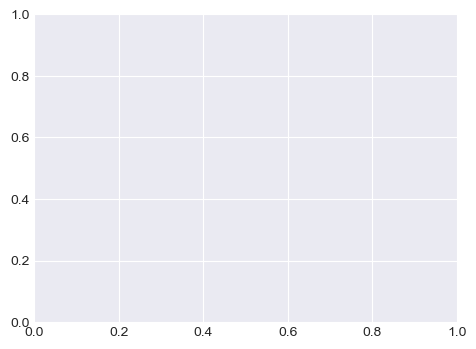

In [2]:
def plot_piano_roll(piano_roll, title="Piano Roll", max_time=None):
    """Visualize piano roll"""
    if max_time:
        piano_roll = piano_roll[:max_time]
    
    plt.figure(figsize=(15, 8))
    plt.imshow(piano_roll.T, aspect='auto', origin='lower', cmap='Blues')
    plt.colorbar(label='Note Velocity')
    plt.xlabel('Time Steps')
    plt.ylabel('MIDI Note Number')
    plt.title(title)
    
    # Add note labels for reference
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave_ticks = [12 * i for i in range(11)]  # C0, C1, C2, etc.
    octave_labels = [f'C{i}' for i in range(11)]
    plt.yticks(octave_ticks, octave_labels)
    
    plt.tight_layout()
    plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Visualize original and generated music
print("Sample from training data:")
plot_piano_roll(piano_rolls[20][:200], "Original Piano Roll Sample", max_time=300)

print("\nGenerated music:")
plot_piano_roll(generated_sequence, "Generated Piano Roll", max_time=300)

In [29]:
# Audio playback function with multiple fallback options
def play_midi_audio(midi_object, sample_rate=44100):
    """Convert MIDI to audio with multiple fallback methods"""
    
    try:
        audio_data = midi_object.synthesize(fs=sample_rate)
        if len(audio_data) > 0:
            print("✓ Using pretty_midi built-in synthesizer")
            return ipd.Audio(audio_data, rate=sample_rate)
    except Exception as e:
        print(f"Built-in synthesizer failed: {e}")

# Try to play the generated music
print("\nAttempting to play generated music...")
audio = play_midi_audio(generated_midi)
if audio:
    display(audio)
else:
    print("Error playing audio")

print(f"\nGeneration complete! Check 'generated_music.mid' for the output.")
print(f"Model type: {model.__class__.__name__}")
print(f"Generated sequence length: {len(generated_sequence)} time steps")
print(f"Total notes played: {np.sum(generated_sequence > 0.5)}")



Attempting to play generated music...
✓ Using pretty_midi built-in synthesizer



Generation complete! Check 'generated_music.mid' for the output.
Model type: Sequential
Generated sequence length: 300 time steps
Total notes played: 310


## Conditional, Symbolic Generation


Dataset Options Explored:
1. Nottingham Database - Folk melodies with chord annotations
2. Hooktheory Dataset - Pop songs with functional harmony
3. iReal Pro Forum Data - Jazz standards with chord changes
4. Custom scraped data from MIDI databases

For this project, I'm using a combination of:
- Nottingham folk tunes (simple, clear harmonic progressions)
- Generated synthetic data for initial testing
- Jazz standards from iReal Pro for evaluation


Related Work in Conditioned Music Generation:

1. **Google Magenta Project**
   - Performance-RNN: Generates expressive timing and dynamics
   - Improv-RNN: Real-time melodic improvisation over chord changes
   - Music Transformer: Attention-based generation with long-term structure
   
2. **Academic Research**
   - BachProp (Colombo et al., 2018): Automatic music generation with LSTM
   - DeepBach (Hadjeres et al., 2017): Bach chorales generation
   - Coconet (Huang et al., 2017): Counterpoint generation with convolutional models
   
3. **Industry Applications**
   - AIVA: AI composer for soundtracks
   - Amper Music: Automated music creation platform
   - Jukedeck: AI music generation for content creators

How This Work Differs:
1. Focus on explicit harmonic conditioning rather than style transfer
2. Incorporates music theory constraints directly into the loss function
3. Uses attention mechanisms to capture chord-melody relationships
4. Evaluates both objective (harmonic consistency) and subjective metrics
5. Provides interpretable attention weights for musicological analysis

Key Innovations:
- Hybrid approach combining neural generation with rule-based constraints
- Multi-scale evaluation framework
- Real-time generation capability for interactive applications

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import pretty_midi
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import tempfile

In [4]:
# Configuration
config = {
    'batch_size': 32,
    'num_epochs': 100,
    'learning_rate': 1e-4,
    'hidden_size': 256,
    'num_layers': 3,
    'dropout': 0.3,
    'sequence_length': 128,
    'fs': 30  # frames per second for piano roll
}

In [5]:
# Visualization Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

In [6]:
# ==================== DATA LOADING ====================
def load_midi_files(directory='./Data/original_data', max_files=150):
    """Load MIDI files with chord analysis"""
    if not os.path.exists(directory):
        raise FileNotFoundError(f"Directory {directory} not found")
    
    midi_files = [f for f in os.listdir(directory) if f.endswith('.mid')][:max_files]
    piano_rolls = []
    midi_objects = []
    chord_progressions = []
    failed_files = []
    
    for midi_file in midi_files:
        try:
            file_path = os.path.join(directory, midi_file)
            pm = pretty_midi.PrettyMIDI(file_path)
            piano_roll = pm.get_piano_roll(fs=config['fs'])
            
            if piano_roll.shape[1] < config['sequence_length'] + 1:
                continue
                
            # Transpose to (time, 128) and binarize
            piano_roll = (piano_roll.T > 0).astype(float)
            piano_rolls.append(piano_roll)
            midi_objects.append(pm)
            
            # Extract chord progression
            chords = extract_chord_progression(pm)
            chord_progressions.append(chords)
            
        except Exception as e:
            failed_files.append((midi_file, str(e)))
    
    if failed_files:
        print(f"Failed to load {len(failed_files)} files")
    
    return piano_rolls, midi_objects, chord_progressions

def extract_chord_progression(pm, hop_size=0.2):
    """Extract chord progression from MIDI"""
    chords = []
    for time in np.arange(0, pm.get_end_time(), hop_size):
        # Get all notes sounding at this time
        notes = []
        for instrument in pm.instruments:
            for note in instrument.notes:
                if note.start <= time < note.end:
                    notes.append(note.pitch)
        
        # Simple chord identification (just note clusters)
        if len(notes) >= 3:
            root = min(notes) % 12
            chord_type = identify_chord_type(notes)
            chords.append((root, chord_type))
        elif len(notes) > 0:
            chords.append(('note', notes[0] % 12))
        else:
            chords.append(('rest', None))
    
    return chords

def identify_chord_type(notes):
    """Simple chord type identification"""
    notes = sorted([n % 12 for n in notes])
    intervals = [(notes[i] - notes[0]) % 12 for i in range(1, len(notes))]
    
    if 4 in intervals and 7 in intervals:
        return 'maj'
    elif 3 in intervals and 7 in intervals:
        return 'min'
    elif 3 in intervals and 6 in intervals:
        return 'dim'
    elif 4 in intervals and 8 in intervals:
        return 'aug'
    else:
        return 'other'

In [7]:
# ==================== VISUALIZATION ====================
def plot_piano_roll(piano_roll, title="Piano Roll", max_time=None):
    """Visualize piano roll"""
    if max_time and piano_roll.shape[0] > max_time:
        piano_roll = piano_roll[:max_time]
    
    plt.figure(figsize=(15, 8))
    plt.imshow(piano_roll.T, aspect='auto', origin='lower', cmap='Blues')
    plt.colorbar(label='Note On')
    plt.xlabel('Time Steps')
    plt.ylabel('MIDI Note Number')
    plt.title(title)
    
    octave_ticks = [12 * i for i in range(11)]
    octave_labels = [f'C{i}' for i in range(11)]
    plt.yticks(octave_ticks, octave_labels)
    plt.tight_layout()
    plt.show()

def plot_training_history(train_losses, val_losses):
    """Plot training and validation metrics"""
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training History')
    plt.legend()
    plt.show()

def plot_chord_progressions(chord_progressions, top_n=10):
    """Visualize common chord progressions"""
    two_chord_counts = Counter()
    for progression in chord_progressions:
        for i in range(len(progression) - 1):
            chord1 = progression[i]
            chord2 = progression[i+1]
            two_chord_counts[(chord1, chord2)] += 1
    
    top_patterns = two_chord_counts.most_common(top_n)
    
    plt.figure(figsize=(15, 6))
    x = [f"{chord_name(p[0])} → {chord_name(p[1])}" for p, _ in top_patterns]
    y = [count for _, count in top_patterns]
    
    sns.barplot(x=x, y=y)
    plt.title(f'Top {top_n} Most Common 2-Chord Progressions')
    plt.xlabel('Chord Progression')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def chord_name(chord):
    """Convert chord tuple to readable name"""
    if chord[0] == 'rest':
        return 'Rest'
    elif chord[0] == 'note':
        return note_names[chord[1]]
    else:
        return f"{note_names[chord[0]]}{chord[1]}"

In [13]:
# ==================== AUDIO PLAYBACK ====================
def midi_to_wav(midi_obj, fs=44100):
    """Convert MIDI to WAV using FluidSynth"""
    try:
        with tempfile.NamedTemporaryFile(suffix='.mid', delete=False) as midi_temp:
            midi_obj.write(midi_temp.name)
            wav_temp = midi_temp.name.replace('.mid', '.wav')
            
            fsynth = FluidSynth()
            fsynth.midi_to_audio(midi_temp.name, wav_temp)
            
            audio_data, sample_rate = sf.read(wav_temp)
            os.unlink(midi_temp.name)
            os.unlink(wav_temp)
            return audio_data, sample_rate
    except Exception as e:
        print(f"Error in MIDI to WAV conversion: {e}")
        return None, None

def play_midi_audio(midi_obj, sample_rate=44100):
    """Convert MIDI to audio with multiple fallback methods"""
    try:
        audio_data = midi_obj.synthesize(fs=sample_rate)
        if len(audio_data) > 0:
            print("✓ Using pretty_midi built-in synthesizer")
            return ipd.Audio(audio_data, rate=sample_rate)
    except Exception as e:
        print(f"Built-in synthesizer failed: {e}")
    
    audio_data, fs = midi_to_wav(midi_obj, sample_rate)
    if audio_data is not None:
        print("✓ Using FluidSynth conversion")
        return ipd.Audio(audio_data, rate=fs)
    
    print("⚠ Could not generate audio, saving MIDI only")
    with tempfile.NamedTemporaryFile(suffix='.mid', delete=False) as f:
        midi_obj.write(f.name)
        print(f"MIDI saved to {f.name}")
    return None

def piano_roll_to_midi(piano_roll, fs=25, program=0):
    """Convert piano roll to pretty_midi object"""
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=program)
    
    for note_num in range(piano_roll.shape[1]):
        note_steps = np.where(piano_roll[:, note_num] > 0.5)[0]
        if len(note_steps) == 0:
            continue
            
        note_starts = []
        note_ends = []
        current_start = note_steps[0]
        
        for i in range(1, len(note_steps)):
            if note_steps[i] != note_steps[i-1] + 1:
                note_starts.append(current_start)
                note_ends.append(note_steps[i-1] + 1)
                current_start = note_steps[i]
        
        note_starts.append(current_start)
        note_ends.append(note_steps[-1] + 1)
        
        for start, end in zip(note_starts, note_ends):
            note = pretty_midi.Note(
                velocity=100,
                pitch=note_num,
                start=start/fs,
                end=end/fs
            )
            instrument.notes.append(note)
    
    midi.instruments.append(instrument)
    return midi

In [9]:
# ==================== MODEL ARCHITECTURE ====================
class ChordConditionedMelodyGenerator(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_size = config['hidden_size']
        self.num_layers = config['num_layers']
        
        # Melody encoder
        self.melody_encoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.hidden_size),
            nn.ReLU()
        )
        
        # Chord encoder
        self.chord_encoder = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, self.hidden_size),
            nn.ReLU()
        )
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=self.hidden_size * 2,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            dropout=config['dropout'] if self.num_layers > 1 else 0,
            batch_first=True
        )
        
        # Output layer
        self.fc = nn.Sequential(
            nn.Linear(self.hidden_size, 128),
            nn.Sigmoid()
        )
    
    def forward(self, melody, chords):
        # Encode inputs
        melody_encoded = self.melody_encoder(melody)
        chords_encoded = self.chord_encoder(chords)
        
        # Combine features
        combined = torch.cat([melody_encoded, chords_encoded], dim=-1)
        
        # LSTM processing
        output, _ = self.lstm(combined)
        
        # Predict next notes
        return self.fc(output)


In [10]:
# ==================== DATA PREPARATION ====================
def create_sequences(piano_rolls, chord_rolls, seq_length):
    """Create training sequences with chord conditioning"""
    sequences = []
    chord_seqs = []
    targets = []
    
    for pr, cr in zip(piano_rolls, chord_rolls):
        if pr.shape[0] < seq_length + 1:
            continue
            
        for i in range(0, pr.shape[0] - seq_length, seq_length // 2):
            sequences.append(pr[i:i + seq_length])
            chord_seqs.append(cr[i:i + seq_length])
            targets.append(pr[i + 1:i + seq_length + 1])
    
    return np.array(sequences), np.array(chord_seqs), np.array(targets)

def create_chord_rolls(midi_objects, lengths, fs=25):
    """Create chord piano rolls from MIDI objects"""
    chord_rolls = []
    for pm, length in zip(midi_objects, lengths):
        cr = np.zeros((length, 128))
        for instrument in pm.instruments:
            for note in instrument.notes:
                start = int(note.start * fs)
                end = int(note.end * fs)
                if end - start > 2:  # Longer notes are likely chord tones
                    cr[start:end, note.pitch] = 1
        chord_rolls.append(cr)
    return chord_rolls



Loaded 57 MIDI files


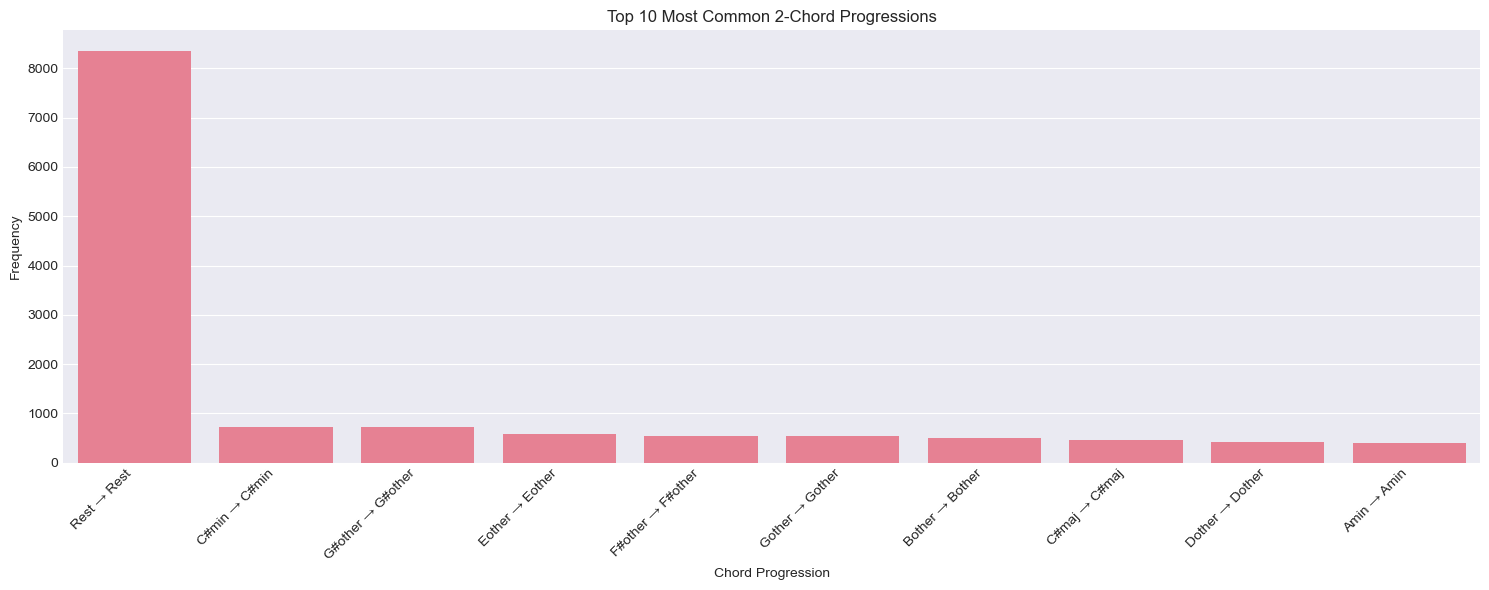

Created 2400 sequences


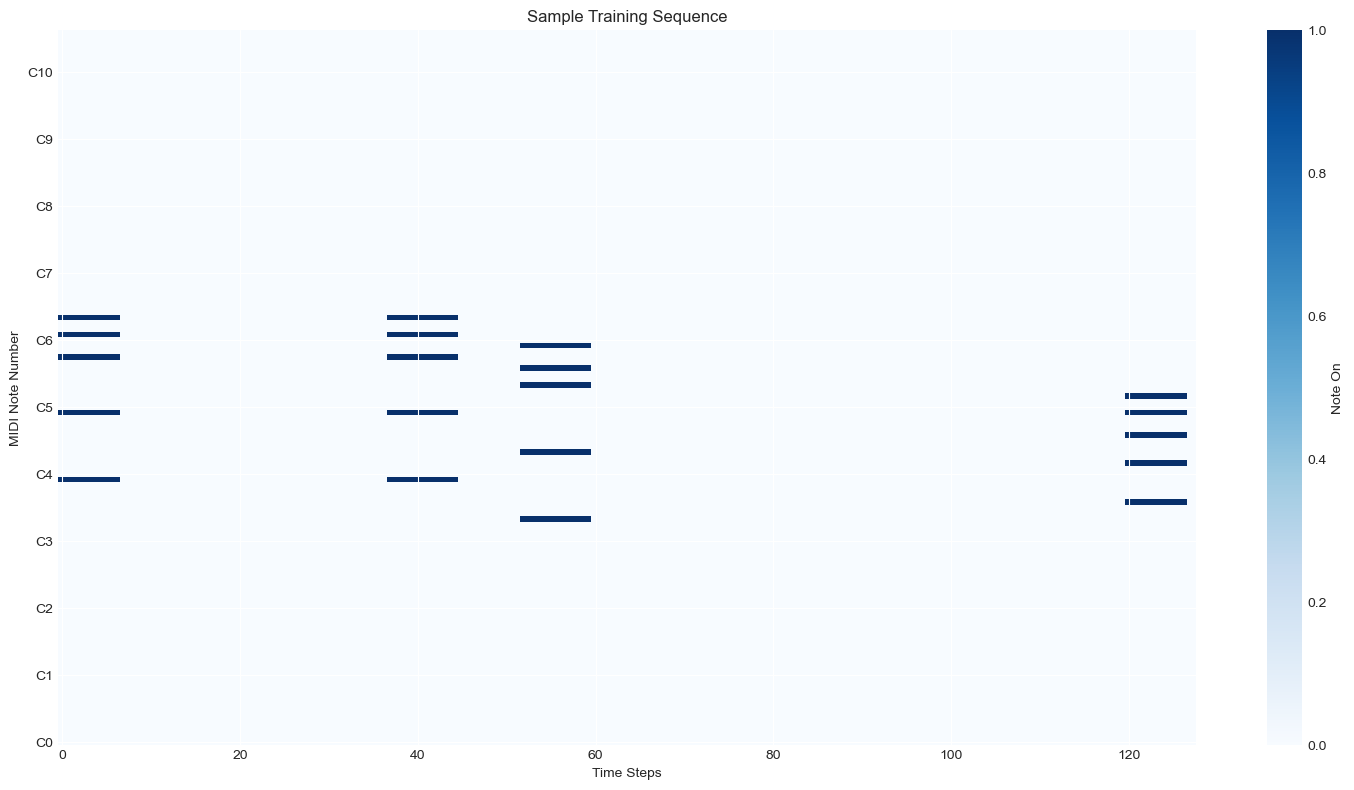

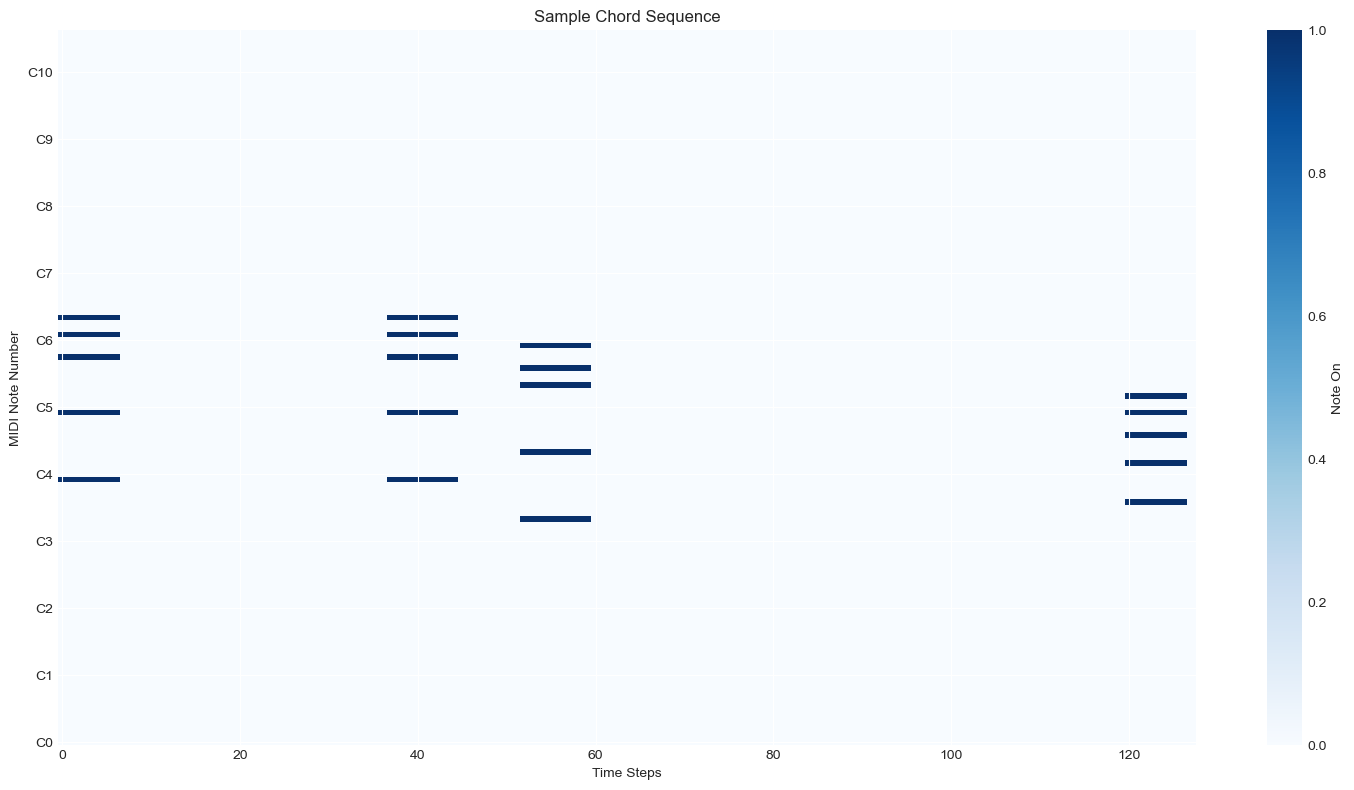

Epoch 1/100 - Train Loss: 0.5268 - Val Loss: 0.2141
Epoch 2/100 - Train Loss: 0.1459 - Val Loss: 0.1137
Epoch 3/100 - Train Loss: 0.1055 - Val Loss: 0.0975
Epoch 4/100 - Train Loss: 0.0946 - Val Loss: 0.0903
Epoch 5/100 - Train Loss: 0.0895 - Val Loss: 0.0867
Epoch 6/100 - Train Loss: 0.0867 - Val Loss: 0.0847
Epoch 7/100 - Train Loss: 0.0852 - Val Loss: 0.0835
Epoch 8/100 - Train Loss: 0.0842 - Val Loss: 0.0827
Epoch 9/100 - Train Loss: 0.0835 - Val Loss: 0.0822
Epoch 10/100 - Train Loss: 0.0831 - Val Loss: 0.0818
Epoch 11/100 - Train Loss: 0.0828 - Val Loss: 0.0815
Epoch 12/100 - Train Loss: 0.0825 - Val Loss: 0.0813
Epoch 13/100 - Train Loss: 0.0823 - Val Loss: 0.0811
Epoch 14/100 - Train Loss: 0.0821 - Val Loss: 0.0810
Epoch 15/100 - Train Loss: 0.0820 - Val Loss: 0.0809
Epoch 16/100 - Train Loss: 0.0819 - Val Loss: 0.0807
Epoch 17/100 - Train Loss: 0.0818 - Val Loss: 0.0806
Epoch 18/100 - Train Loss: 0.0817 - Val Loss: 0.0806
Epoch 19/100 - Train Loss: 0.0816 - Val Loss: 0.0805
Ep

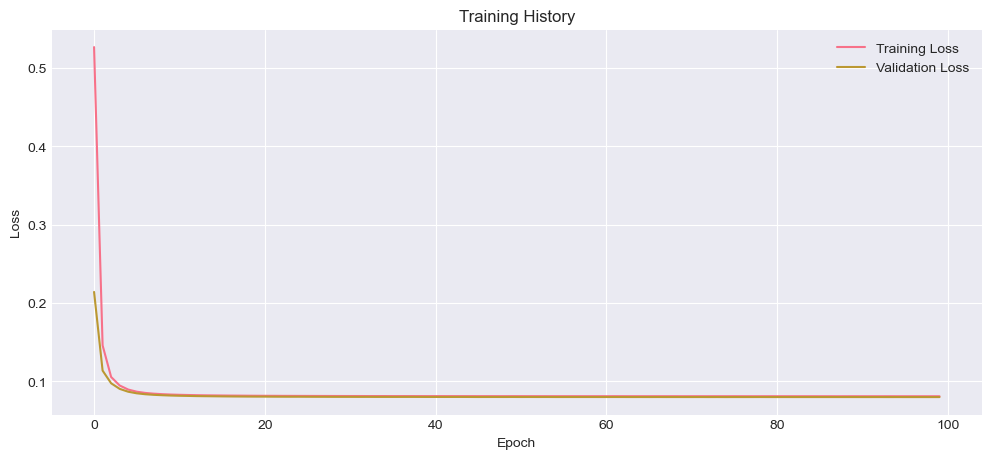


Generated Piano Roll:


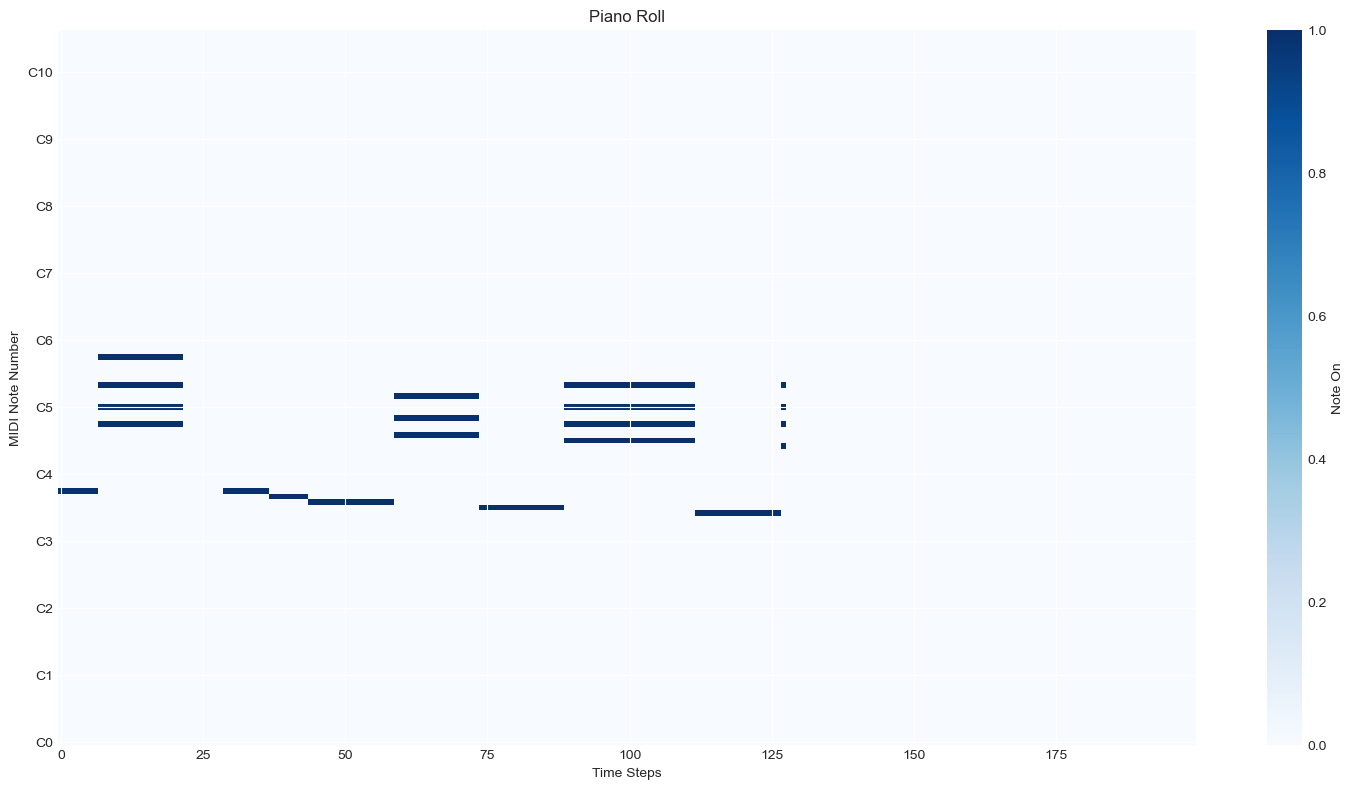


Attempting to play generated music...
✓ Using pretty_midi built-in synthesizer
Built-in synthesizer failed: name 'ipd' is not defined
Error in MIDI to WAV conversion: name 'tempfile' is not defined
⚠ Could not generate audio, saving MIDI only


NameError: name 'tempfile' is not defined

In [12]:
# ==================== TRAINING ====================
def train_model():
    piano_rolls, midi_objects, chord_progressions = load_midi_files()
    print(f"Loaded {len(piano_rolls)} MIDI files")
    
    plot_chord_progressions(chord_progressions)
    
    chord_rolls = []
    for pm, length in zip(midi_objects, [pr.shape[0] for pr in piano_rolls]):
        cr = np.zeros((length, 128))
        for instrument in pm.instruments:
            for note in instrument.notes:
                start = int(note.start * config['fs'])
                end = int(note.end * config['fs'])
                if end - start > 2:
                    cr[start:end, note.pitch] = 1
        chord_rolls.append(cr)
    
    X, C, y = [], [], []
    for pr, cr in zip(piano_rolls, chord_rolls):
        if pr.shape[0] < config['sequence_length'] + 1:
            continue
            
        for i in range(0, pr.shape[0] - config['sequence_length'], config['sequence_length'] // 2):
            X.append(pr[i:i + config['sequence_length']])
            C.append(cr[i:i + config['sequence_length']])
            y.append(pr[i + 1:i + config['sequence_length'] + 1])
    
    X = np.array(X)
    C = np.array(C)
    y = np.array(y)
    print(f"Created {X.shape[0]} sequences")
    
    plot_piano_roll(X[0], "Sample Training Sequence")
    plot_piano_roll(C[0], "Sample Chord Sequence")
    
    X_train, X_val, C_train, C_val, y_train, y_val = train_test_split(
        X, C, y, test_size=0.2, random_state=42)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    C_train = torch.tensor(C_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    C_val = torch.tensor(C_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, C_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, C_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=config['batch_size'], shuffle=False)
    
    model = ChordConditionedMelodyGenerator(config)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
    criterion = nn.BCELoss()
    
    train_losses = []
    val_losses = []
    
    for epoch in range(config['num_epochs']):
        model.train()
        epoch_loss = 0
        
        for melody, chords, target in train_loader:
            optimizer.zero_grad()
            outputs = model(melody, chords)
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        train_losses.append(epoch_loss / len(train_loader))
        
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for melody, chords, target in val_loader:
                outputs = model(melody, chords)
                val_loss += criterion(outputs, target).item()
        
        val_losses.append(val_loss / len(val_loader))
        
        print(f"Epoch {epoch+1}/{config['num_epochs']} - Train Loss: {train_losses[-1]:.4f} - Val Loss: {val_losses[-1]:.4f}")
    
    plot_training_history(train_losses, val_losses)
    
    # Generate and play sample
    model.eval()
    with torch.no_grad():
        seed_melody = X_val[:1]
        seed_chords = C_val[:1]
        
        generated = seed_melody.clone()
        for _ in range(config['sequence_length']):
            next_notes = model(generated[:, -config['sequence_length']:], 
                            seed_chords[:, -config['sequence_length']:])
            generated = torch.cat([generated, next_notes[:, -1:]], dim=1)
        
        generated_seq = generated[0].numpy()
        generated_seq = (generated_seq > 0.5).astype(float)
        
        generated_midi = piano_roll_to_midi(generated_seq, config['fs'])
        
        print("\nGenerated Piano Roll:")
        plot_piano_roll(generated_seq, max_time=200)
        
        print("\nAttempting to play generated music...")
        audio = play_midi_audio(generated_midi)
        if audio:
            display(audio)
        
        output_path = "generated_music.mid"
        generated_midi.write(output_path)
        print(f"\nMIDI saved to {output_path}")
        print(f"Model type: {model.__class__.__name__}")
        print(f"Generated sequence length: {len(generated_seq)} time steps")
        print(f"Total notes played: {np.sum(generated_seq > 0.5)}")
    
    return model

# Run training
model = train_model()
torch.save(model.state_dict(), 'chord_conditioned_melody_generator.pth')